In [7]:
## Lorenz 63 model code
from matplotlib import projections
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import xgboost
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras import optimizers 
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
import tensorflow_addons as tfa


In [8]:
## model configuration
x_len = 3       # size of the state vector
dt = 0.01        # timestep length
nstep = 500     # number of timesteps

## model parameters - you can add some random noise to these parameters too
sigma = 10.0
rho = 28.0
beta = 8.0/3.0

def lorenz63_deriv( x ):
    assert x_len == 3, 'lorenz 63 only works for x_len == 3'
    dxdt = np.zeros( 3 )
    dxdt[0] = -sigma * x[0] + sigma *x[1]
    dxdt[1] = x[0] * (rho - x[2]) - x[1]
    dxdt[2] = x[0] * x[1] - beta * x[2]
    return dxdt

def model( xin, nstep):
    x = xin.copy()
    xtraj = np.zeros(( x_len, nstep+1 ))
    for j in range(nstep):
        xtraj[ :, j ] = x.copy()
        dxdt = lorenz63_deriv( x )
        x = x + dt * dxdt #step
    xtraj[ :, nstep ] = x.copy()
    return xtraj


## add some random 'jitter' to the initial state
xin = np.random.standard_normal(x_len) * 0.1 + np.array([1,0,0])

## integrate the model forward
xtraj = model( xin , nstep)

## illustrate the output
#plt.scatter(xtraj[0,:], xtraj[1,:])
#plt.show()

In [9]:
print("xin")
print(xin)

print("xtraj")
print("xtraj shape :: ", np.shape(xtraj))
print(xtraj)



xin
[ 0.83101895 -0.05151167  0.05751587]
xtraj
xtraj shape ::  (3, 501)
[[  0.83101895   0.74276589   0.68661038 ... -14.12992616 -13.27310787
  -12.30032218]
 [ -0.05151167   0.18121078   0.38696049 ...  -5.56174334  -3.54525092
   -1.71174372]
 [  0.05751587   0.05555404   0.05541857 ...  41.877461    41.54659894
   40.90925461]]


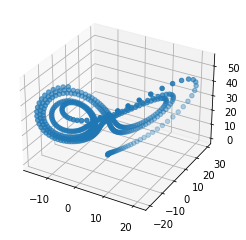

In [10]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(xtraj[0,:], xtraj[1,:], xtraj[2,:])
plt.show()

In [11]:
#data set generation
def generateDataSetOfLorenz63(numberOfIterations, nstep):
    dataList = []
    for i in range(numberOfIterations):
        xin = np.random.standard_normal(x_len) * 0.1 + np.array([1,0,0])
        xtraj = model( xin , nstep).T
        dataList.append(xtraj)
    dataSet = np.stack(dataList)
    return dataSet


In [12]:
#change the nstreps here
nstep = 700
dataSet = generateDataSetOfLorenz63(1000, nstep)

yData = dataSet[:, ]
print("data set shape ::: ", np.shape(dataSet))


data set shape :::  (1000, 701, 3)


In [13]:
inputPosition = dataSet[:, 0, :]
finalPositionList = dataSet[:,700, :]
print("finalPosition set shape ::: ", np.shape(finalPositionList))

finalPosition set shape :::  (1000, 3)


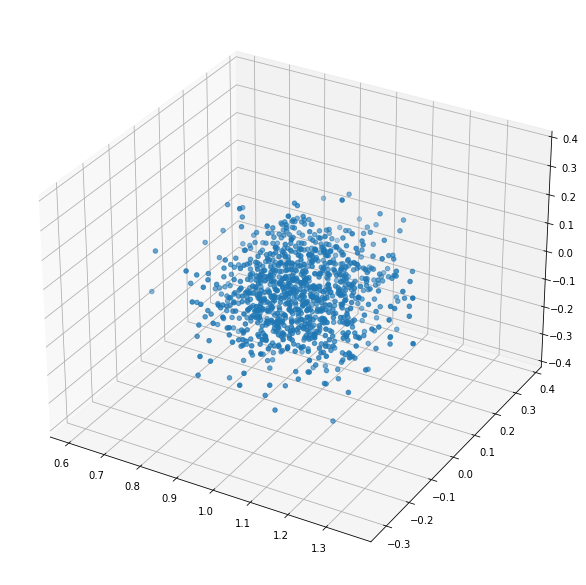

In [14]:
fig = plt.figure()

ax = plt.axes(projection='3d')
ax.figure.set_size_inches(18.5, 10.5)
ax.scatter3D(inputPosition[:, 0], inputPosition[:, 1], inputPosition[:, 2])
plt.show()

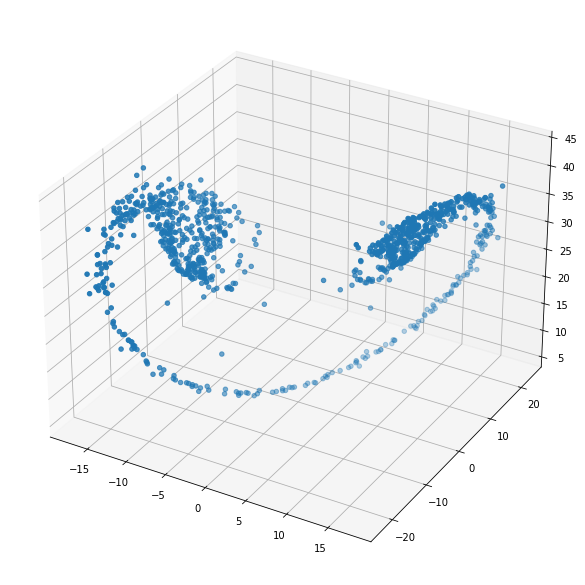

In [15]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.figure.set_size_inches(18.5, 10.5)
ax.scatter3D(finalPositionList[:, 0], finalPositionList[:, 1], finalPositionList[:, 2])
plt.show()

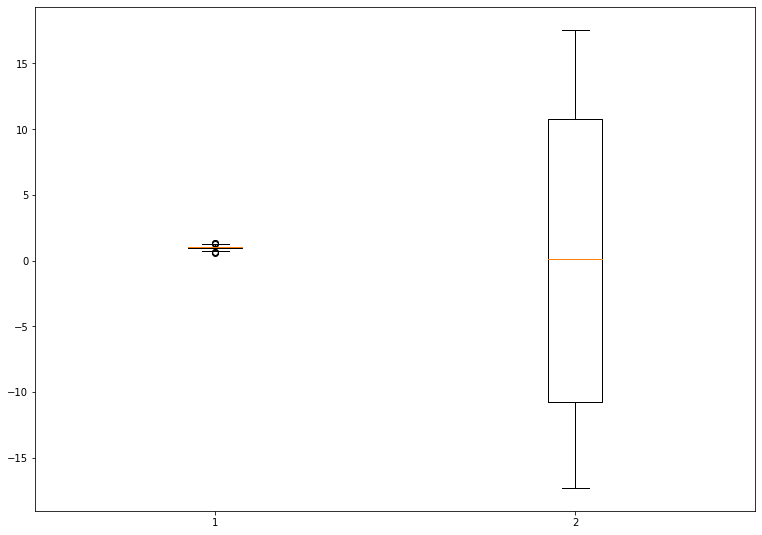

In [16]:
data = [inputPosition[:, 0], finalPositionList[:, 0]]
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot(data)
 
# show plot
plt.show()

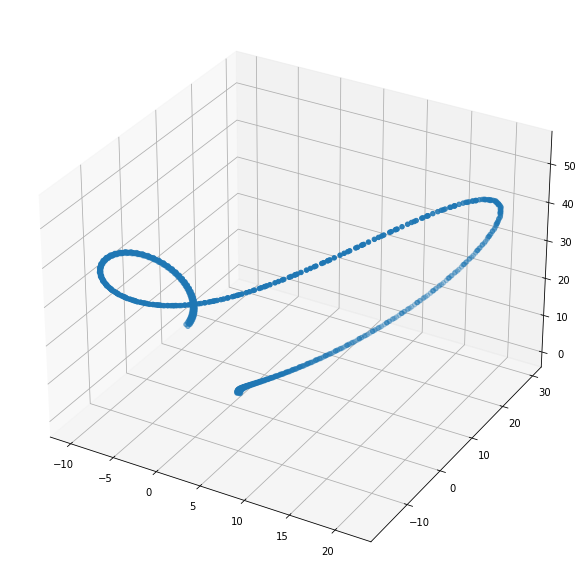

In [17]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.figure.set_size_inches(18.5, 10.5)
ax.scatter3D(dataSet[0:10:, 0:100, 0], dataSet[0:10, 0:100, 1], dataSet[0:10, 0:100, 2])
plt.show()

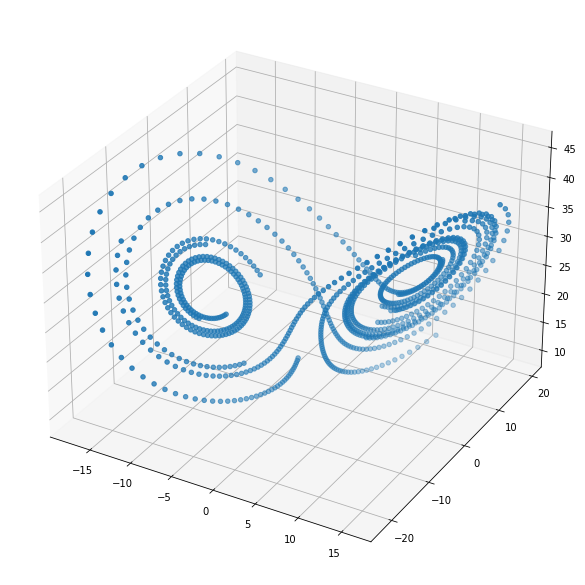

In [18]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.figure.set_size_inches(18.5, 10.5)
ax.scatter3D(dataSet[0:10:, 600:700, 0], dataSet[0:10, 600:700, 1], dataSet[0:10, 600:700, 2])
plt.show()

In [19]:
#this varible indicates the lenght of time series required in the prediction
labelLength = 400
#length of the time series of trianing data
trainingLength = nstep - labelLength + 1
finalIndex = nstep + 1


x1 = dataSet[:, 0:trainingLength, 0]
x2 = dataSet[:, 0:trainingLength, 1]
x3 = dataSet[:, 0:trainingLength, 2]

y1 = dataSet[:, trainingLength:finalIndex, 0]
y2 = dataSet[:, trainingLength:finalIndex, 1]
y3 = dataSet[:, trainingLength:finalIndex, 2]

xTrain1, xTest1, yTrain1, yTest1 = train_test_split(x1, y1, test_size = 0.3, random_state = 1)
xTrain2, xTest2, yTrain2, yTest2 = train_test_split(x2, y2, test_size = 0.3, random_state = 1)
xTrain3, xTest3, yTrain3, yTest3 = train_test_split(x3, y3, test_size = 0.3, random_state = 1)
print("x dimension :", np.shape(x1))
print("y dimension :", np.shape(y1))

print("xTrain dimension :", np.shape(xTrain1))
print("yTrain dimension :", np.shape(yTrain1))

print("xTest dimension :", np.shape(xTest1))
print("yTest dimension :", np.shape(yTest1))

x dimension : (1000, 301)
y dimension : (1000, 400)
xTrain dimension : (700, 301)
yTrain dimension : (700, 400)
xTest dimension : (300, 301)
yTest dimension : (300, 400)


In [20]:
#random forest
def trainAndPreditWithRandomForest(xTrain, xTest, yTrain, yTest):
    

    regressor=RandomForestRegressor(n_estimators=100)

    regressor.fit(xTrain,yTrain)

    yPredicted = regressor.predict(xTest)

    print("Accuracy:",regressor.score(xTest, yTest))   

    return yPredicted

yPredicted1 = trainAndPreditWithRandomForest(x1, xTest1, y1, yTest1)
yPredicted2 = trainAndPreditWithRandomForest(x2, xTest2, y2, yTest2)
yPredicted3 = trainAndPreditWithRandomForest(x3, xTest3, y3, yTest3)


Accuracy: 0.9693748746313272
Accuracy: 0.983720536940788
Accuracy: 0.9800696242061234


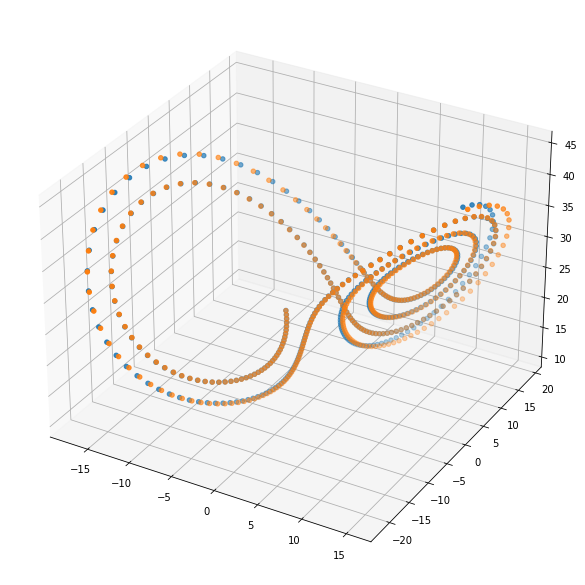

In [21]:

def plotTwo3Dset(yPredicted1, yPredicted2, yPredicted3, yTest1, yTest2, yTest3):
    ax = plt.axes(projection='3d')
    ax.figure.set_size_inches(18.5, 10.5)
    ax.scatter3D(yPredicted1, yPredicted2, yPredicted3)
    ax.scatter3D(yTest1, yTest2, yTest3)
    plt.show()
plotTwo3Dset(yPredicted1[0], yPredicted2[0], yPredicted3[0], yTest1[0], yTest2[0], yTest3[0])

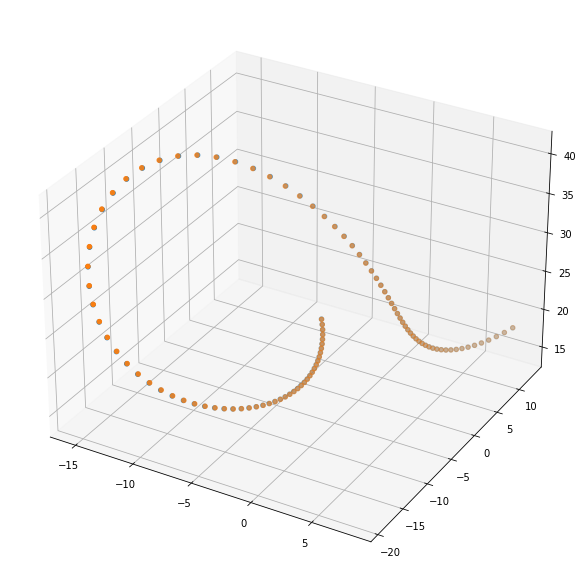

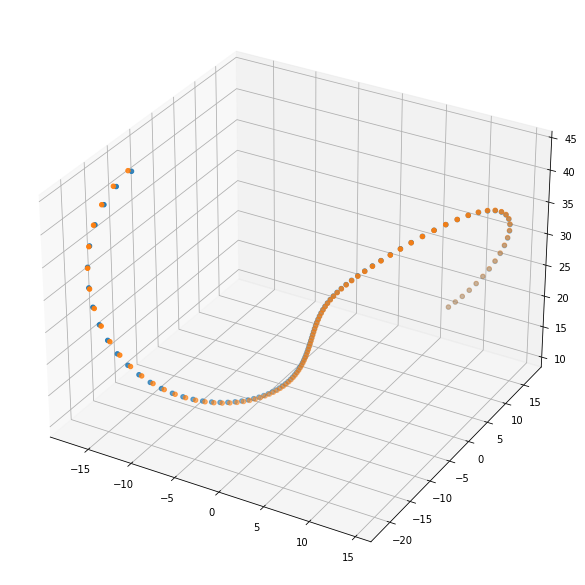

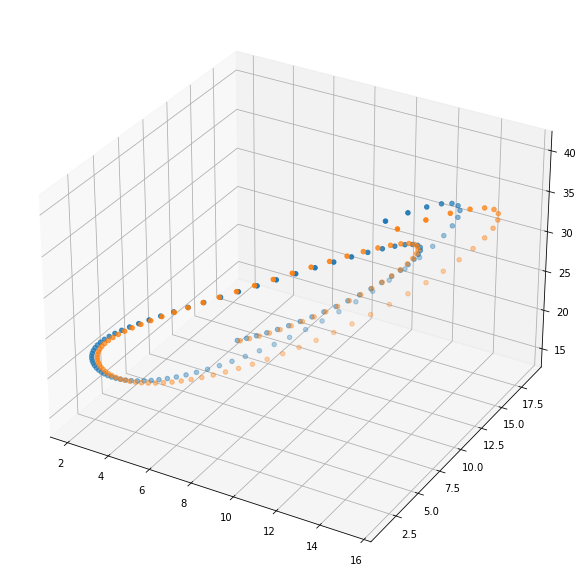

In [22]:
plotTwo3Dset(yPredicted1[0, 0:100], yPredicted2[0, 0:100], yPredicted3[0, 0:100], yTest1[0, 0:100], yTest2[0, 0:100], yTest3[0, 0:100])
plotTwo3Dset(yPredicted1[0, 100:200], yPredicted2[0, 100:200], yPredicted3[0, 100:200], yTest1[0, 100:200], yTest2[0, 100:200], yTest3[0, 100:200])
plotTwo3Dset(yPredicted1[0, 300:401], yPredicted2[0, 300:401], yPredicted3[0, 300:401], yTest1[0, 300:401], yTest2[0, 300:401], yTest3[0, 300:401])

In [23]:
#guassian process regression
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussianProcess = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussianProcess.fit(D2trainingData, yTrain)

print("Accuracy:", gaussianProcess.score(D2testingData, yTest))

NameError: name 'D2trainingData' is not defined

In [ ]:
#xgboost
multiUutputRegressor = MultiOutputRegressor(xgboost.XGBRFRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)).fit(D2trainingData, yTrain)
predictions = multiUutputRegressor.predict(D2testingData)
meanSquaredError = np.sqrt(mean_squared_error(yTest, predictions))

print("Accuracy:", multiUutputRegressor.score(D2testingData, yTest))
print("MSE : ", meanSquaredError)

[22:21:48] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[22:21:49] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[22:21:50] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy: -3.485981714777781
MSE :  18.71540243540705


In [6]:
#lstm

nSteps = 500
nFeatures = x_len #3
verbose = 0
batchSize = 30
epochs = 50

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(nSteps, nFeatures)))
model.add(Dense(3))
model.compile(optimizer='adam', loss='mse')
model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(), optimizer='adam', metrics=['accuracy'])
model.fit(xTrain, yTrain, epochs = epochs, verbose = verbose, batch_size = batchSize)
_, accuracy = model.evaluate(xTest, yTest, batch_size=batchSize, verbose=0)

print("Accuracy : ", accuracy)


2022-05-09 10:17:29.057907: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-09 10:17:29.058818: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Accuracy :  0.0


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

input_df = pd.read_csv('inputs_rpmodel.csv')
output_df = pd.read_csv('outputs_rpmodel.csv')
feature_names = input_df.columns.tolist()

    



In [4]:

X_train, X_test, y_train, y_test = train_test_split(input_df, output_df["gpp"])

print(" y test ", y_test.shape)


 y test  (250,)


In [6]:
clf = GradientBoostingRegressor()
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
expected = y_test



In [7]:
print(predicted.shape)

(250,)


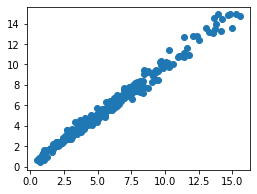

In [16]:
plt.figure(figsize=(4, 3))
plt.scatter(expected, predicted)
#plt.plot('--k')
#plt.axis('tight')
plt.show()